# MPST(Movie Plot Synopses with Tags): Tag Prediction

### Description:

### Context:
Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks, metadata, visual and emotional experiences. Such information can be valuable in building automatic systems to create tags for movies. Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance. In this case study, we set out to the task of collecting a corpus of movie plot synopses and tags. We describe a methodology that enabled us to build a fine-grained set of around 70 tags exposing heterogeneous characteristics of movie plots and the multi-label associations of these tags with some 14K movie plot synopses. We investigate how these tags correlate with movies and the flow of emotions throughout different types of movies. Finally, we use this corpus to explore the feasibility of inferring tags from plot synopses. We expect the corpus will be useful in other tasks where analysis of narratives is relevant.

### Sources and Useful links:
Please find the paper here: https://www.aclweb.org/anthology/L18-1274

This dataset was published in LREC 2018@Miyazaki, Japan.

Keywords Tag generation for movies, Movie plot analysis, Multi-label dataset, Narrative texts

More information is available here http://ritual.uh.edu/mpst-2018/


### Citation:
@InProceedings{KAR18.332, author = {Sudipta Kar and Suraj Maharjan and A. Pastor López-Monroy and Thamar Solorio}, title = {{MPST}: A Corpus of Movie Plot Synopses with Tags}, booktitle = {Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018)}, year = {2018}, month = {May}, date = {7-12}, location = {Miyazaki, Japan}, editor = {Nicoletta Calzolari (Conference chair) and Khalid Choukri and Christopher Cieri and Thierry Declerck and Sara Goggi and Koiti Hasida and Hitoshi Isahara and Bente Maegaard and Joseph Mariani and Hélène Mazo and Asuncion Moreno and Jan Odijk and Stelios Piperidis and Takenobu Tokunaga}, publisher = {European Language Resources Association (ELRA)}, address = {Paris, France}, isbn = {979-10-95546-00-9}, language = {english} }

Acknowledgements
We would like to thank the National Science Foundation for partially funding this work under award 1462141. We are also grateful to Prasha Shrestha, Giovanni Molina, Deepthi Mave, and Gustavo Aguilar for reviewing and providing valuable feedback during the process of creating tag clusters.

<p style='font-size:18px'><b> Problem Statement </b></p>
Suggest the tags based on the plot synopses of the given movies.

### Dataset
Contains all the IMDB id, title, plot synopsis, tags for the movies. There are 14,828 movies' data in total. The split column indicates where the data instance resides in the Train/Dev/Test split.

<h3> Real world Objectives and Constraints </h3>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact movie search results generated based on tags.
3. No strict latency constraints.

<h2>Mapping the problem to Machine Learning problem </h2>

<h3>Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A movie on MPST dataset might be about any of horror, comedy, romantic etc. at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>


# Exploratory Data Analysis

In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import seaborn as sns
import spacy
from tqdm import tqdm
from krovetzstemmer import Stemmer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import KeyedVectors
import warnings
from scipy.sparse import hstack, csr_matrix
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from datetime import datetime
from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import median
from wordcloud import WordCloud

### Loading Data

In [0]:
data = pd.read_csv('mpst_full_data.csv')
data.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


### Shape of Dataset

In [0]:
print('No of rows in MPST Dataset: ', data.shape[0])

No of rows in MPST Dataset:  14828


### Checking for NaN or null entries

In [0]:
print('No of null entries in imdb_id: ', data['imdb_id'].isnull().sum())
print('No of null entries in title: ', data['title'].isnull().sum())
print('No of null entries in plot_synopsis: ', data['plot_synopsis'].isnull().sum())
print('No of null entries in tags: ', data['tags'].isnull().sum())
print('No of null entries in split: ', data['split'].isnull().sum())
print('No of null entries in synopsis_source: ', data['synopsis_source'].isnull().sum())

No of null entries in imdb_id:  0
No of null entries in title:  0
No of null entries in plot_synopsis:  0
No of null entries in tags:  0
No of null entries in split:  0
No of null entries in synopsis_source:  0


So, this dataset has no null/NaN entries.

### Checking for duplications

In [0]:
print('No of duplicates based on title: ', data.duplicated(['title']).sum())
print('No of duplicates based on plot_synopsis: ', data.duplicated(['plot_synopsis']).sum())
print('No of duplicates based on both title and plot_synopsis: ', data.duplicated(['title', 'plot_synopsis']).sum())

No of duplicates based on title:  1071
No of duplicates based on plot_synopsis:  980
No of duplicates based on both title and plot_synopsis:  651


In [0]:
data[data.duplicated(['title'])].head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
643,tt0082031,Arthur,Arthur Bach is a rich socialite from a financi...,"comedy, entertaining",test,imdb
776,tt0837565,The Witches of Eastwick,This unsold TV series pilot opens with three y...,paranormal,train,imdb
1198,tt0800320,Clash of the Titans,"In ancient times, after defeating their predec...","fantasy, violence, flashback, good versus evil...",train,wikipedia
1228,tt0319970,Carrie,Several people are being interviewed in a poli...,"paranormal, revenge, gothic, prank",train,wikipedia
1231,tt0814335,The Stepfather,The movie starts off with Grady Edwards (Dylan...,"murder, flashback",train,imdb


In [0]:
data[data['title'] == 'Arthur']

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
278,tt1334512,Arthur,Arthur (Russell Brand) is a drunken playboy wh...,"entertaining, stupid",test,imdb
643,tt0082031,Arthur,Arthur Bach is a rich socialite from a financi...,"comedy, entertaining",test,imdb


In [0]:
data[data['title'] == 'The Witches of Eastwick']

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
320,tt0094332,The Witches of Eastwick,"Alexandra Medford, Jane Spofford and Sukie Rid...",comedy,test,imdb
776,tt0837565,The Witches of Eastwick,This unsold TV series pilot opens with three y...,paranormal,train,imdb


>The Titles appeared to same but the plot and tags are different. So its time to check plot synopsis duplication.

In [0]:
text = data[data.duplicated(['title', 'plot_synopsis'])]['plot_synopsis'][1198]
data[data['plot_synopsis'] == text]

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
182,tt0082186,Clash of the Titans,"In ancient times, after defeating their predec...","cult, revenge, psychedelic",train,wikipedia
1198,tt0800320,Clash of the Titans,"In ancient times, after defeating their predec...","fantasy, violence, flashback, good versus evil...",train,wikipedia
10042,tt1589998,Clash of the Titans,"In ancient times, after defeating their predec...","good versus evil, violence",val,wikipedia


In [0]:
data = data.drop_duplicates(['title', 'plot_synopsis'], keep = 'first')
print('No of duplicates after droping based on both title and plot_synopsis: ', data.duplicated(['title', 'plot_synopsis']).sum())
print('No of new rows in the dataset: ', data.shape[0])

No of duplicates after droping based on both title and plot_synopsis:  0
No of new rows in the dataset:  14177


### Distribution of Tags:

In [0]:
def preprocess_tags(s):
    s = re.sub(r"\s+",'_',s)
    s = re.sub(r"\,_+", ' ', s)
    return s

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(' '), binary='true')
y = vectorizer.fit_transform(data['tags'].apply(preprocess_tags))

In [0]:
print('No of Unique tags: ', y.shape[1])

No of Unique tags:  71


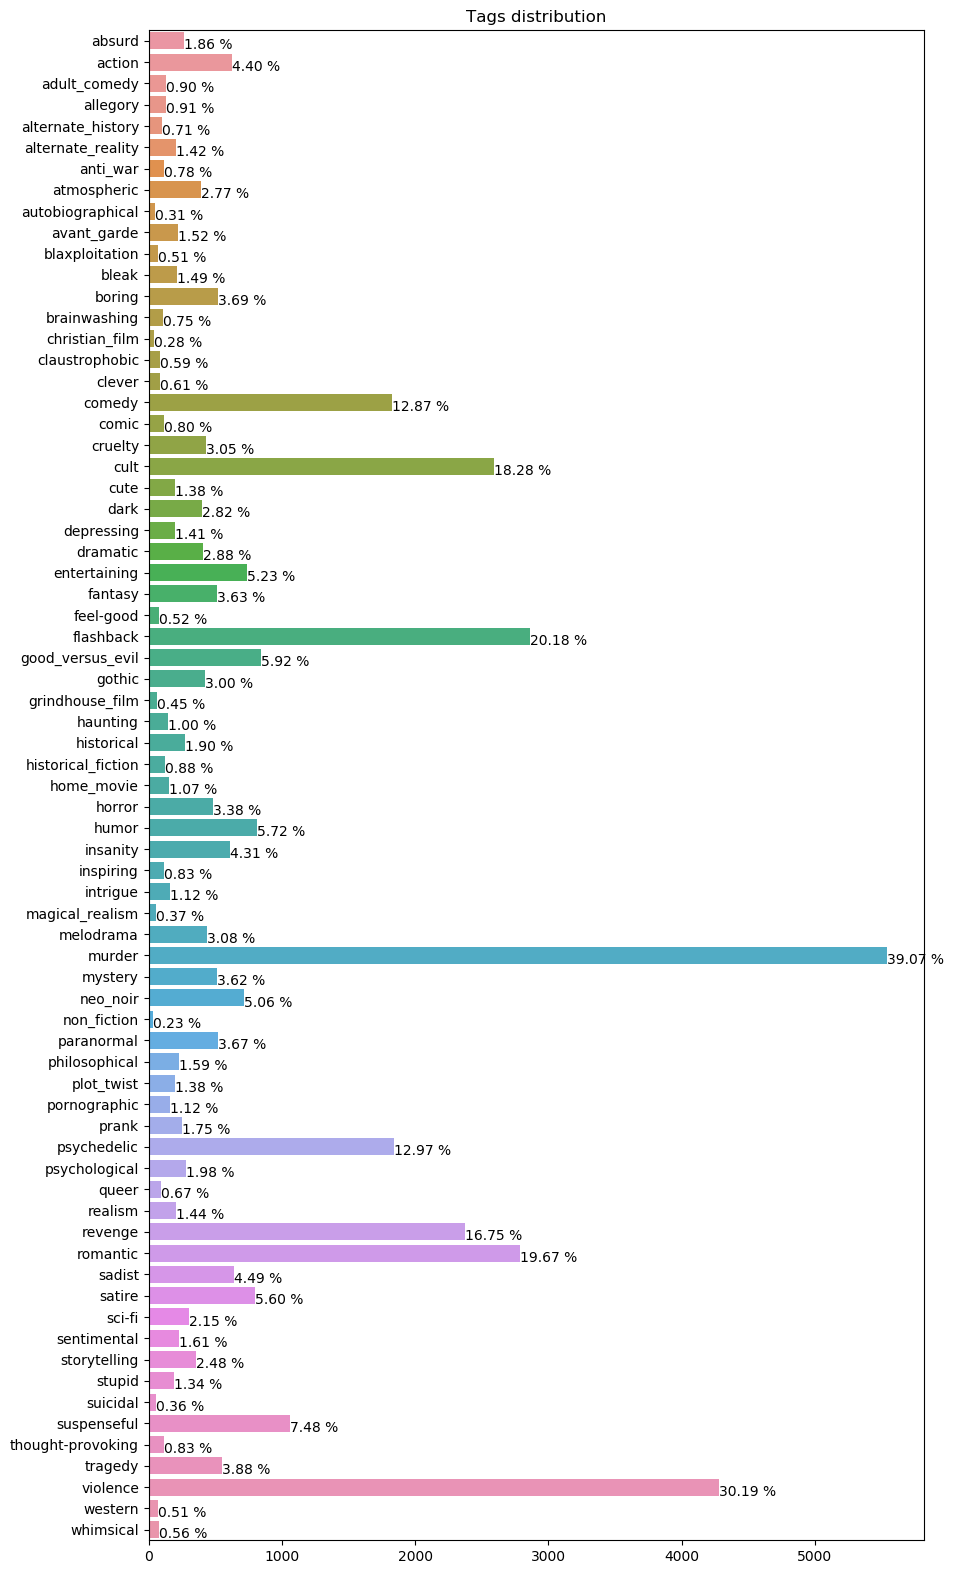

In [0]:
tags = vectorizer.get_feature_names()
total = y.shape[0]
counts = y.toarray().sum(axis = 0)
plt.figure(figsize=(10,20), dpi = 100)
ax = sns.barplot(counts, tags, orientation ='horizontal')

for i in range(len(counts)):
    p = ax.patches[i]
    height = p.get_width()
    ax.text(height, p.get_y()+p.get_height(),
            '{:1.2f} %'.format(counts[i]/total *100),
            ha="left")
    
plt.title('Tags distribution')
plt.show()

Well, this dataset has imbalanced distribution of tags.

### Train-Test split:

Here we are going to use test set to validate. So merging train and val to increase the dataset size.

In [0]:
data['split'] = data['split'].replace('val', 'train')

In [0]:
gb = data.groupby('split')
gdata = [gb.get_group(x) for x in gb.groups]
data_test = pd.DataFrame(gdata[0]).drop(['split'], axis = 1)
data_train = pd.DataFrame(gdata[1]).drop(['split'], axis = 1)

In [0]:
print('Shape of Train data: ', data_train.shape)
print('Shape of Test data: ', data_test.shape)

Shape of Train data:  (11324, 5)
Shape of Test data:  (2853, 5)


In [0]:
data_train.head()

,imdb_id,title,plot_synopsis,tags,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb
5,tt1315981,A Single Man,George Falconer (Colin Firth) approaches a car...,"romantic, queer, flashback",imdb


### Most Frequent tags

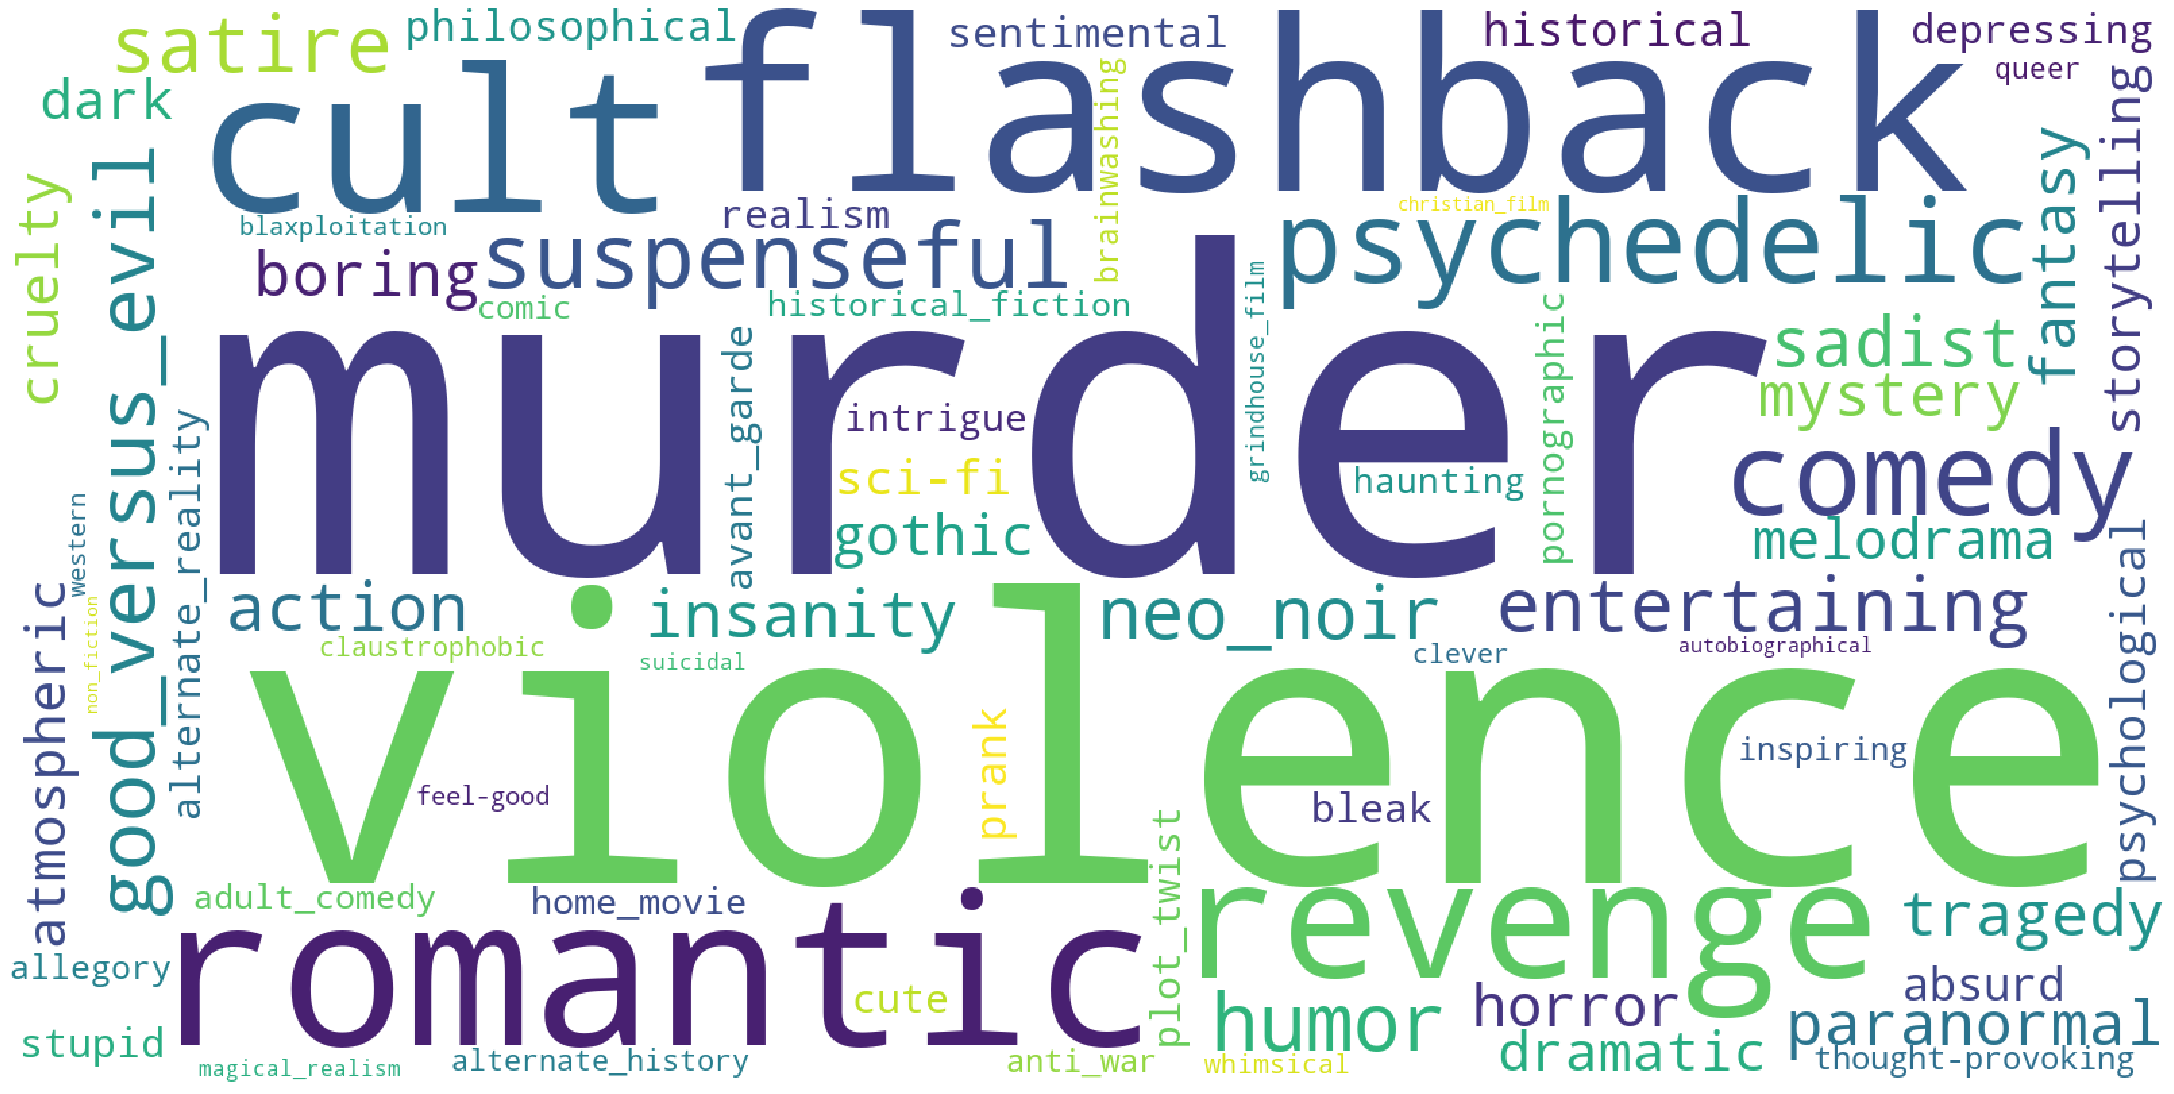

In [0]:
# Ploting word cloud

#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='white',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(dict(zip(tags, counts)))

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [0]:
data_train['tags'] = data_train['tags'].apply(lambda x: preprocess_tags(x))
data_test['tags'] = data_test['tags'].apply(lambda x: preprocess_tags(x))

#### One Hot Encoding for multilabel classification

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(' '), binary='true')
y_train = vectorizer.fit_transform(data_train['tags'])

y_test = vectorizer.transform(data_test['tags'])

## Preprocessing the plot_synopses

1. Remove Name tags like Dr., Mr., Mrs., Miss, Master, etc.
2. Remove stopwords.
3. Remove Special Characters.
4. Stem all the words.
5. Encoding all persons names as 'person'.

In [0]:
name_tags = ['dr', 'mr', 'mrs', 'miss', 'master', 'mister', 'mistress']

re_names = re.compile(r"\b(" + "|".join(name_tags) + ")\\W", re.I)
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
        "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
        'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
        'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
        'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
        'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
        'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
        'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
        'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
        's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
        've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
        "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
        'won', "won't", 'wouldn', "wouldn't"]

In [0]:
nlp = spacy.load('en_core_web_sm')

from sentic import SenticPhrase
mood_tags = ['#interest','#admiration','#sadness','#disgust','#joy','#anger','#fear','#surprise']

stemmer = Stemmer()
def stem(sentence):
    tokens = sentence.split(' ')
    stemmed = ''
    for word in tokens:
        stemmed += stemmer.stem(word) + ' '
    return stemmed

def preprocess_synopses(plot_synopses):
    preprocessed_synopses = []
    sentiments = []
    sentic_vector = []

    for line in tqdm(plot_synopses):
        
        line= re.sub(r'\([^()]*\)', '', line)
        line= re.sub(r"won't", "will not", line)
        line= re.sub(r"can\'t", "can not", line)
        line= re.sub(r"n\'t", " not", line)
        line= re.sub(r"\'re", " are", line)
        line= re.sub(r"\'s", " is", line)
        line= re.sub(r"\'d", " would", line)
        line= re.sub(r"\'ll", " will", line)
        line= re.sub(r"\'t", " not", line)
        line= re.sub(r"\'ve", " have", line)
        line= re.sub(r"\'m", " am", line)
        line= line.replace('"','')
        line= line.replace('\\r', ' ')
        line= line.replace('\\"', ' ')
        line= line.replace('\\n', ' ')
        line= re.sub('[^A-Za-z.,]+', ' ', line)
        line= re_names.sub("", line)
        line= line.replace('.',' . ')
        line= ' '.join(word for word in line.split() if word not in stopwords)
        
        line_nlp  = nlp(line)
        entities = [str(e).strip() for e in line_nlp.ents if e.label_=='PERSON']
        persons = list(set(entities))

        # Replacing character names with 'person'
        line_new = line
        for person in persons:
            line_new = line_new.replace(person, 'person')
            
        line_new = re.sub('[^A-Za-z0-9]+', ' ', line_new)
        line_new = line_new.lower().strip()
        line_new = ' '.join(word for word in line_new.split() if word not in stopwords)
        

        #appending sentiments [neg, neu, pos]
        sentis = []
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(line_new)

        for k in ss:
            sentis.append(ss[k])
        sentiments.append(sentis[:-1])
        
        #Sentic Features
        sentic_feats = []
        sp = SenticPhrase(line_new)
        sentic_feats.extend(list(sp.get_sentics().values()))
        get_mood_tags = sp.get_moodtags()
        sentic_feats.extend([get_mood_tags.get(i,0) for i in mood_tags])
        sentic_feats.append(sp.get_polarity())
        sentic_vector.append(sentic_feats)
        
        #stemming
        line_new = stem(line_new)
        
        #appending the preprocessed string to list
        preprocessed_synopses.append(line_new)

    return preprocessed_synopses, sentiments, sentic_vector

In [0]:
preprocessed_synopses_train, sentiments, sentic_vector = preprocess_synopses(data_train['plot_synopsis'])

100%|██████████████████████████████████████████████| 11324/11324 [20:24<00:00,  9.25it/s]


In [0]:
data_train['plot_synopsis'] = preprocessed_synopses_train
senti_train_df = pd.DataFrame(data = np.array(sentiments), index = data_train.index, columns = ['senti_neg', 'senti_neu', 'senti_pos'])
sentic_train_df = pd.DataFrame(data = sentic_vector, index = data_train.index)
data_train = pd.concat([data_train, senti_train_df, sentic_train_df], axis = 1)

In [0]:
data_train.head()

,imdb_id,title,plot_synopsis,tags,synopsis_source,senti_neg,senti_neu,senti_pos,0,1,...,3,4,5,6,7,8,9,10,11,12
0,tt0057603,I tre volti della paura,note synopsis orginal italy release segment ce...,cult horror gothic murder atmospheric,imdb,0.248,0.645,0.107,0.026446,0.027089,...,0.028069,34,56,13,35,23,16,10,15,0.012960
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,two thousand years ago person sorcerer revel c...,violence,imdb,0.307,0.599,0.094,0.069705,0.295841,...,-0.012250,22,17,7,15,15,9,3,0,0.068159
3,tt0113862,Mr. Holland's Opus,person dutch not morning person anyone standar...,inspiring romantic stupid feel-good,imdb,0.098,0.777,0.125,-0.072825,0.128578,...,-0.094554,64,61,33,54,35,40,15,30,-0.077458
4,tt0086250,Scarface,may cuba man name person montana claim asylum ...,cruelty murder dramatic cult violence atmosphe...,imdb,0.176,0.715,0.109,-0.070050,0.109609,...,-0.048369,66,82,44,59,26,38,25,18,-0.053670
5,tt1315981,A Single Man,person falconer approach car accident middle s...,romantic queer flashback,imdb,0.158,0.727,0.115,0.051571,0.074016,...,-0.037302,19,28,10,14,20,12,6,17,0.025095


In [0]:
data_train.to_csv('data_train.csv')

In [0]:
data_train = pd.read_csv('data_train.csv', index_col = 0)

In [0]:
preprocessed_synopses_test, sentiments_test, sentic_vector_test = preprocess_synopses(data_test['plot_synopsis'])

data_test['plot_synopsis'] = preprocessed_synopses_test
senti_test_df = pd.DataFrame(data = np.array(sentiments_test), index = data_test.index, columns = ['senti_neg', 'senti_neu', 'senti_pos'])
sentic_test_df = pd.DataFrame(sentic_vector_test, index = data_test.index)
data_test = pd.concat([data_test, senti_test_df, sentic_test_df], axis = 1)
data_test.to_csv('data_test.csv')

100%|████████████████████████████████████████████████| 2853/2853 [05:08<00:00,  9.24it/s]


In [0]:
data_test = pd.read_csv('data_test.csv', index_col = 0)

In [0]:
data_test.head()

,imdb_id,title,plot_synopsis,tags,synopsis_source,senti_neg,senti_neu,senti_pos,0,1,...,3,4,5,6,7,8,9,10,11,12
2,tt0033045,The Shop Around the Corner,person gift store budapest workplace person kr...,romantic,imdb,0.149,0.689,0.162,-0.127631,0.045985,...,-0.044400,27,30,19,20,7,15,6,6,-0.083523
15,tt1937113,Call of Duty: Modern Warfare 3,hour end previous game death traitorous genera...,good_versus_evil,imdb,0.218,0.688,0.094,0.008955,0.039492,...,-0.116065,75,89,35,78,45,26,29,21,-0.058744
19,tt0102007,The Haunted,creepy scary story center around person family...,paranormal horror haunting,imdb,0.246,0.744,0.010,-0.090400,0.006800,...,0.047300,6,6,3,1,2,1,1,0,-0.010000
24,tt2005374,The Frozen Ground,film open person motel room year old person ha...,dramatic murder,wikipedia,0.227,0.687,0.086,0.078702,0.151638,...,0.060489,23,21,6,13,7,5,4,15,0.079468
27,tt1411238,No Strings Attached,years agowe see two young kid name person sitt...,boring adult_comedy cute flashback romantic en...,imdb,0.095,0.740,0.165,-0.092477,0.008964,...,-0.045550,29,47,31,29,32,13,19,22,-0.061775


In [0]:
# One Hot encoding the synopsis_Source
sources_train = pd.get_dummies(data_train['synopsis_source'])
sources_test = pd.get_dummies(data_test['synopsis_source'])

senti_train = data_train[['senti_neg', 'senti_neu', 'senti_pos']]
senti_test = data_test[['senti_neg', 'senti_neu', 'senti_pos']]

sentic_train = data_train.drop(['synopsis_source','imdb_id', 'title', 'plot_synopsis', 'tags','senti_neg', 'senti_neu', 'senti_pos' ], axis = 1)
sentic_test = data_test.drop(['synopsis_source', 'imdb_id', 'title', 'plot_synopsis', 'tags','senti_neg', 'senti_neu', 'senti_pos' ], axis = 1)

In [0]:
sentis_train = np.hstack((sources_train, senti_train, sentic_train))
sentis_test = np.hstack((sources_test, senti_test, sentic_test))

# Machine Learning Models:

We are excluding imdb_id and title columns as they are no of use. Its not good to tag a movie from its title because plot is where most information is present.

## 1. OneVsRestClassifier with LogisticRegression

### OneVsRestClassifier (LR) with features: BoW features(ngrams = (1,5), max = 25000)

In [0]:
bow_plot_synopsis = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}',ngram_range = (1,5), max_features = 25000)

plot_synopsis_bow_train = bow_plot_synopsis.fit_transform(data_train['plot_synopsis'])

plot_synopsis_bow_test = bow_plot_synopsis.transform(data_test['plot_synopsis'])

print('Shape of bow matrix, train: ', plot_synopsis_bow_train.shape)

Shape of bow matrix, train:  (11324, 25000)


In [0]:
X_train_bow = hstack((sentis_train, plot_synopsis_bow_train))
X_test_bow = hstack((sentis_test, plot_synopsis_bow_test))

In [0]:
# Scaling the values using MinMaxNormalization
scaler = MinMaxScaler()

scaler.fit(X_train.toarray())

X_train_bow = scaler.transform(X_train_bow.toarray())
X_test_bow = scaler.transform(X_test_bow.toarray())

In [0]:
warnings.filterwarnings('ignore')
start = datetime.now()
classifier_lrbow = OneVsRestClassifier(LogisticRegression(C= 0.025, solver = 'liblinear', class_weight = 'balanced'), n_jobs =-1)
classifier_lrbow.fit(X_train_bow, y_train)
predictions_lrbow = classifier_lrbow.predict(X_test_bow)

precision_lrbow = metrics.precision_score(y_test, predictions_lrbow, average='micro')
recall_lrbow = metrics.recall_score(y_test, predictions_lrbow, average='micro')
f1_lrbow = metrics.f1_score(y_test, predictions_lrbow, average='micro')
 

print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1_lrbow, recall_lrbow, precision_lrbow))


 micro-F1: 0.3821,  Recall: 0.3878,  Precision: 0.3765


### OneVsRestClassifier  (LR)  with features: Tfidf features(ngrams = (1,5), sublinear_tf = True, max = 25000)


In [0]:
vectorizer_plot_synopsis = TfidfVectorizer(min_df = 5,  use_idf = True, sublinear_tf = True, analyzer='word', token_pattern=r'\w{1,}', ngram_range = (1,5), max_features = 25000)

plot_synopsis_tfidf_train = vectorizer_plot_synopsis.fit_transform(data_train['plot_synopsis'])

plot_synopsis_tfidf_test = vectorizer_plot_synopsis.transform(data_test['plot_synopsis'])

print('Shape of tfidf matrix, train: ', plot_synopsis_tfidf_train.shape)

Shape of tfidf matrix, train:  (11324, 25000)


In [0]:
X_train_tfidf = hstack((sentis_train, plot_synopsis_tfidf_train))
X_test_tfidf = hstack((sentis_test, plot_synopsis_tfidf_test))

In [0]:
# Scaling the values using MinMaxNormalization
scaler = MinMaxScaler()

scaler.fit(X_train.toarray())

X_train_tfidf = scaler.transform(X_train_tfidf.toarray())
X_test_tfidf = scaler.transform(X_test_tfidf.toarray())

In [0]:
warnings.filterwarnings('ignore')
start = datetime.now()
classifier_lrtfidf = OneVsRestClassifier(LogisticRegression(C= 0.035, solver = 'liblinear', class_weight = 'balanced'), n_jobs =-1)
classifier_lrtfidf.fit(X_train_tfidf, y_train)
predictions_lrtfidf = classifier_lrtfidf.predict(X_test_tfidf)

precision_lrtfidf = metrics.precision_score(y_test, predictions_lrtfidf, average='micro')
recall_lrtfidf = metrics.recall_score(y_test, predictions_lrtfidf, average='micro')
f1_lrtfidf = metrics.f1_score(y_test, predictions_lrtfidf, average='micro')
 
print('Time Taken : ', datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1_lrtfidf, recall_lrtfidf, precision_lrtfidf))


Time Taken :  0:01:19.956366
 micro-F1: 0.4045,  Recall: 0.4328,  Precision: 0.3798


### OneVsRestClassifier  (LR)  with pretrained-Glove features: avg-w2v features


In [0]:
gloveFile = 'D:\AAIC datasets\ADC\glove.42B.300d.txt'

In [0]:
import numpy as np
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r', encoding = 'utf8')
    model = {}
    num_lines = sum(1 for line in f)
    f.seek(0,0)
    for line in tqdm(f, total = num_lines):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [0]:
model_glove = loadGloveModel(gloveFile)

Loading Glove Model


100%|██████████████████████████████████████████████████████████████████████| 1917495/1917495 [04:53<00:00, 6526.38it/s]


Done. 1917495  words loaded!


In [0]:
words = []
for i in data_train['plot_synopsis']:
    words.extend(i.split(' '))
    
print("all the words in the train corpus: ", len(words))
words = set(words)
print("the unique words in the train corpus: ", len(words))
inter_words = set(model_glove.keys()).intersection(words)
print('No of train words present in pre-trained model: ', len(inter_words))

print("The number of words that are present in both model and our corpus: ", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_corpus = {}
for i in words:
    if i in model_glove:
        words_corpus[i] = model_glove[i]

with open('glove_w2v_mpst_train', 'wb') as f:
    pickle.dump(words_corpus, f)
print('glove w2v for train is saved to disk')

all the words in the train corpus:  5364689
the unique words in the train corpus:  56988
No of train words present in pre-trained model:  48317
The number of words that are present in both model and our corpus:  48317 ( 84.785 %)
glove w2v for train is saved to disk


In [0]:
with open('glove_w2v_mpst_train', 'rb') as f:
    glove_model_w2v = pickle.load(f)

In [0]:
avg_w2v_train = []; # the avg-w2v for each sentence is stored in this list
for sentence in tqdm(data_train['plot_synopsis']): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if word in glove_model_w2v:
            vector += glove_model_w2v[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_train.append(vector)

print('Shape of w2v train: ',(len(avg_w2v_train),len(avg_w2v_train[0])))

avg_w2v_test = []; # the avg-w2v for each sentence is stored in this list
for sentence in tqdm(data_test['plot_synopsis']): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if word in glove_model_w2v:
            vector += glove_model_w2v[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_test.append(vector)

print('Shape of w2v test: ',(len(avg_w2v_test),len(avg_w2v_test[0])))

100%|██████████████████████████████████████████████████████████████████████████| 11324/11324 [00:09<00:00, 1213.45it/s]


Shape of w2v train:  (11324, 300)


100%|████████████████████████████████████████████████████████████████████████████| 2853/2853 [00:02<00:00, 1261.86it/s]


Shape of w2v test:  (2853, 300)


In [0]:
X_train = hstack((sentis_train, csr_matrix(avg_w2v_train)))
X_test = hstack((sentis_test, csr_matrix(avg_w2v_test)))

In [0]:
scaler = MinMaxScaler()

scaler.fit(X_train.toarray())

X_train_w2v = scaler.transform(X_train.toarray())
X_test_w2v = scaler.transform(X_test.toarray())

In [0]:
warnings.filterwarnings('ignore')

start = datetime.now()
classifier_w2v = OneVsRestClassifier(LogisticRegression(C=1.2,solver = 'liblinear', class_weight = 'balanced',verbose = 1), n_jobs =-1)
classifier_w2v .fit(X_train_w2v, y_train)
predictions_w2v  = classifier_w2v .predict(X_test_w2v)

precision_w2v  = metrics.precision_score(y_test, predictions_w2v , average='micro')
recall_w2v  = metrics.recall_score(y_test, predictions_w2v , average='micro')
f1_w2v  = metrics.f1_score(y_test, predictions_w2v , average='micro')
 
print('Time Taken : ', datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1_w2v , recall_w2v , precision_w2v ))


Time Taken :  0:01:08.137928
 micro-F1: 0.2442,  Recall: 0.6527,  Precision: 0.1502


### OneVsRestClassifier  (LR) with features: tfidf weighted -w2v features


In [0]:
tfidf_model = TfidfVectorizer(min_df = 5, use_idf = True, sublinear_tf = True)
tfidf_model.fit(data_train['plot_synopsis'])

dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [0]:
tfidf_w2v_train = []; # the avg-w2v for each sentence is stored in this list
for sentence in tqdm(data_train['plot_synopsis']): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_model_w2v) and (word in tfidf_words):
            vec = glove_model_w2v[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_train.append(vector)

print('Shape of w2v train: ',(len(tfidf_w2v_train),len(tfidf_w2v_train[0])))

tfidf_w2v_test = []; # the avg-w2v for each sentence is stored in this list
for sentence in tqdm(data_test['plot_synopsis']): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_model_w2v) and (word in tfidf_words):
            vec = glove_model_w2v[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_test.append(vector)

print('Shape of w2v test: ',(len(tfidf_w2v_test),len(tfidf_w2v_test[0])))

100%|███████████████████████████████████████████| 11324/11324 [04:38<00:00, 40.59it/s]


Shape of w2v train:  (11324, 300)


100%|█████████████████████████████████████████████| 2853/2853 [01:13<00:00, 39.01it/s]


Shape of w2v test:  (2853, 300)


In [0]:
with open('tfidfw2v_train', 'wb') as f:
    pickle.dump(tfidf_w2v_train, f)
with open('tfidfw2v_test', 'wb') as f:
    pickle.dump(tfidf_w2v_test, f)

In [0]:
with open('tfidfw2v_train', 'rb') as f:
    tfidf_w2v_train = pickle.load(f)
with open('tfidfw2v_test', 'rb') as f:
    tfidf_w2v_test = pickle.load(f)

In [0]:
X_train = hstack((sentis_train, csr_matrix(tfidf_w2v_train)))
X_test = hstack((sentis_test, csr_matrix(tfidf_w2v_test)))

scaler = MinMaxScaler()

scaler.fit(X_train.toarray())

X_train_tfidfw2v = scaler.transform(X_train.toarray())
X_test_tfidfw2v  = scaler.transform(X_test.toarray())

In [0]:
start = datetime.now()
classifier_lrtw = OneVsRestClassifier(LogisticRegression(C=2.0, solver = 'liblinear', class_weight = 'balanced', verbose=1), n_jobs =-1)
classifier_lrtw.fit(csr_matrix(X_train_tfidfw2v), csr_matrix(y_train))
predictions_lrtw = classifier_lrtw.predict(X_test_tfidfw2v)

precision_lrtw = metrics.precision_score(y_test, predictions_lrtw, average='micro')
recall_lrtw = metrics.recall_score(y_test, predictions_lrtw, average='micro')
f1_lrtw = metrics.f1_score(y_test, predictions_lrtw, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1_lrtw, recall_lrtw, precision_lrtw))

Time taken :  0:01:03.473008
 micro-F1: 0.2020,  Recall: 0.6176,  Precision: 0.1207


### OneVsRestClassifier  (LR)  with features: w2v, bow, tfidf

In [0]:
X_train = hstack((sentis_train, csr_matrix(avg_w2v_train), plot_synopsis_bow_train, plot_synopsis_tfidf_train))
X_test = hstack((sentis_test ,csr_matrix(avg_w2v_test), plot_synopsis_bow_test,  plot_synopsis_tfidf_test))

In [0]:
scaler = MinMaxScaler()

scaler.fit(X_train.toarray())

X_train_mixed = scaler.transform(X_train.toarray())
X_test_mixed = scaler.transform(X_test.toarray())

In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(C= 0.016, max_iter = 300, solver = 'liblinear', class_weight = 'balanced', verbose = 1), n_jobs =-1)
classifier.fit(csr_matrix(X_train_mixed), csr_matrix(y_train))
predictions = classifier.predict(X_test_mixed)

precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:01:45.374148
 micro-F1: 0.4101,  Recall: 0.4357,  Precision: 0.3872


### OneVsRestClassifier with ComplementNB

ComplementNB is only be useful for count features. ComplementNB is better than MultinomialNB as it works better with unbalanced classes.

#### BoW

In [0]:
from sklearn.naive_bayes import ComplementNB
start = datetime.now()
classifier = OneVsRestClassifier(ComplementNB(alpha = 0.45, norm =  True), n_jobs =-1)
classifier.fit(csr_matrix(X_train_bow), csr_matrix(y_train))
predictions = classifier.predict(X_test_bow)

precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:00:12.725156
 micro-F1: 0.3645,  Recall: 0.3535,  Precision: 0.3763


#### Tfidf

In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(ComplementNB(alpha = 0.46, norm =  True), n_jobs =-1)
classifier.fit(csr_matrix(X_train_tfidf), csr_matrix(y_train))
predictions = classifier.predict(X_test_tfidf)

precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:00:12.860384
 micro-F1: 0.3840,  Recall: 0.4020,  Precision: 0.3674


### Lr.SVM with tuned parameters

#### BoW features

In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss = 'hinge', class_weight = 'balanced', alpha = 1e-2), n_jobs =-1)
classifier.fit(X_train_bow, y_train)
predictions = classifier.predict(X_test_bow)

precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:05:09.708196
 micro-F1: 0.3721,  Recall: 0.3600,  Precision: 0.3850


#### Tfidf Features

In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss = 'hinge', class_weight = 'balanced', alpha = 1e-1), n_jobs =-1)
classifier.fit(X_train_tfidf, y_train)
predictions = classifier.predict(X_test_tfidf)

precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:04:53.870687
 micro-F1: 0.3831,  Recall: 0.4344,  Precision: 0.3426


#### w2v Features

In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss = 'hinge', class_weight = 'balanced', alpha = 1e-3), n_jobs =-1)
classifier.fit(X_train_w2v, y_train)
predictions = classifier.predict(X_test_w2v)

precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:00:07.985856
 micro-F1: 0.1664,  Recall: 0.7064,  Precision: 0.0943


#### tfidf_w2v features

In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss = 'hinge', class_weight = 'balanced', alpha = 1e-4), n_jobs =-1)
classifier.fit(X_train_tfidfw2v, y_train)
predictions = classifier.predict(X_test_tfidfw2v)

precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:00:10.917827
 micro-F1: 0.1472,  Recall: 0.7057,  Precision: 0.0822


#### w2v, tfidf and bow

In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss = 'hinge', class_weight = 'balanced', alpha = 1e-2), n_jobs =-1)
classifier.fit(X_train_mixed, y_train)
predictions = classifier.predict(X_test_mixed)

precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:11:23.814083
 micro-F1: 0.3588,  Recall: 0.3867,  Precision: 0.3347


## Considering only Top 3 tags

In [0]:
t = y_train.sum(axis=0).tolist()[0]
sorted_tags_i = sorted(range(len(t)), key = lambda i: t[i], reverse= True)
y_train1=y_train[:,sorted_tags_i[:3]]
y_test1 = y_test[:, sorted_tags_i[:3]]

#### LogisticRegression with w2v, tfidf & bow

In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(C= 0.012, max_iter = 300, solver = 'liblinear', class_weight = 'balanced', verbose = 1), n_jobs =-1)
classifier.fit(csr_matrix(X_train_mixed), csr_matrix(y_train1))
predictions = classifier.predict(X_test_mixed)

precision = metrics.precision_score(y_test1, predictions, average='micro')
recall = metrics.recall_score(y_test1, predictions, average='micro')
f1 = metrics.f1_score(y_test1, predictions, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:00:07.339557
 micro-F1: 0.6102,  Recall: 0.6650,  Precision: 0.5637


#### ComplementNB with tfidf features

In [0]:
start = datetime.now()
classifier1 = OneVsRestClassifier(ComplementNB(alpha = 0.46, norm =  True), n_jobs =-1)
classifier1.fit(csr_matrix(X_train_tfidf), csr_matrix(y_train1))
predictions1 = classifier1.predict(X_test_tfidf)

precision = metrics.precision_score(y_test1, predictions1, average='micro')
recall = metrics.recall_score(y_test1, predictions1, average='micro')
f1 = metrics.f1_score(y_test1, predictions1, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:00:02.601516
 micro-F1: 0.5808,  Recall: 0.6387,  Precision: 0.5326


#### Lr.SVM with tfidf features

In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss = 'hinge', class_weight = 'balanced', alpha = 1e-1), n_jobs =-1)
classifier.fit(X_train_tfidf, y_train1)
predictions = classifier.predict(X_test_tfidf)

precision = metrics.precision_score(y_test1, predictions, average='micro')
recall = metrics.recall_score(y_test1, predictions, average='micro')
f1 = metrics.f1_score(y_test1, predictions, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:00:15.172888
 micro-F1: 0.5691,  Recall: 0.6263,  Precision: 0.5214


## Considering only Top 4 Tags

In [0]:
y_train2=y_train[:,sorted_tags_i[:4]]
y_test2 = y_test[:, sorted_tags_i[:4]]

#### LogisticRegression with w2v, tfidf and bow

In [0]:
start = datetime.now()
classifier2 = OneVsRestClassifier(LogisticRegression(C= 0.016, max_iter = 300, solver = 'liblinear', class_weight = 'balanced', verbose = 1), n_jobs =-1)
classifier2.fit(csr_matrix(X_train_mixed), csr_matrix(y_train2))
predictions2 = classifier2.predict(X_test_mixed)

precision = metrics.precision_score(y_test2, predictions2, average='micro')
recall = metrics.recall_score(y_test2, predictions2, average='micro')
f1 = metrics.f1_score(y_test2, predictions2, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:00:10.353748
 micro-F1: 0.5874,  Recall: 0.6395,  Precision: 0.5430


#### ComplementNB with tfidf features only

In [0]:
from sklearn.naive_bayes import ComplementNB
start = datetime.now()
classifier2 = OneVsRestClassifier(ComplementNB(alpha = 0.46, norm =  True), n_jobs =-1)
classifier2.fit(csr_matrix(X_train_tfidf), csr_matrix(y_train2))
predictions2 = classifier2.predict(X_test_tfidf)

precision = metrics.precision_score(y_test2, predictions2, average='micro')
recall = metrics.recall_score(y_test2, predictions2, average='micro')
f1 = metrics.f1_score(y_test2, predictions2, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:00:02.653900
 micro-F1: 0.5524,  Recall: 0.6577,  Precision: 0.4762


#### Lr.SVM with tfidf features

In [0]:
start = datetime.now()
classifier2 = OneVsRestClassifier(SGDClassifier(loss = 'hinge', class_weight = 'balanced', alpha = 1e-1), n_jobs =-1)
classifier2.fit(csr_matrix(X_train_tfidf), csr_matrix(y_train2))
predictions2 = classifier2.predict(X_test_tfidf)

precision = metrics.precision_score(y_test2, predictions2, average='micro')
recall = metrics.recall_score(y_test2, predictions2, average='micro')
f1 = metrics.f1_score(y_test2, predictions2, average='micro')
 
print("Time taken : ", datetime.now() - start)
print(" micro-F1: {:.4f},  Recall: {:.4f},  Precision: {:.4f}".format(f1, recall, precision))

Time taken :  0:00:02.966787
 micro-F1: 0.5556,  Recall: 0.6459,  Precision: 0.4874


### Comparision of Micro-F1 of all models

In [0]:
from  prettytable import PrettyTable

x = PrettyTable([ "Model", "features", "Hyperparameters", "recall(micro)", "precision(micro)" , "f1-micro"])

x.add_row(["OnevsRest(LR)", "BoW ngrams=(1,5)", "C = 0.025",0.3878, 0.3765 , 0.3821])
x.add_row(["OnevsRest(LR)", "Tfidf ngrams=(1,5)", "C = 0.035", 0.4328, 0.3798, 0.4045])
x.add_row(["OnevsRest(LR)","avgw2v","C= 0.12", 0.6527, 0.1502, 0.2442])
x.add_row(["OnevsRest(LR)", "tfidf-w2v", "C = 2.0", 0.6176, 0.1207, 0.2020 ])
x.add_row(["OnevsRest(LR)", "w2v,BoW&Tfidf", "C = 0.016", 0.4357, 0.3872, 0.4101])
print('>>>>> Logistic Regression(71 TAGS)')
print(x)
print()
x = PrettyTable([ "Model", "features", "Hyperparameters", "recall(micro)", "precision(micro)" , "f1-micro"])
x.add_row(["OnevsRest(Lr.SVM)", "BoW ngrams=(1,5)", "alpha = 1e-2",0.3600, 0.3850 , 0.3721 ])
x.add_row(["OnevsRest(Lr.SVM)", "Tfidf ngrams=(1,5)", "alpha = 1e-1",0.4344, 0.3426 , 0.3831])
x.add_row(["OnevsRest(Lr.SVM)","avgw2v", "alpha = 1e-3",0.7064, 0.0943 , 0.1664])
x.add_row(["OnevsRest(Lr.SVM)", "tfidf-w2v", "alpha = 1e-4",0.7057, 0.0822 , 0.1472 ])
x.add_row(["OnevsRest(Lr.SVM)", "w2v,BoW&Tfidf", "alpha = 1e-2",0.3867, 0.3347 , 0.3588])
print('>>>>> Linear SVM(71 TAGS)')
print(x)
print()
x = PrettyTable([ "Model", "features", "Hyperparameters", "recall(micro)", "precision(micro)" , "f1-micro"])
x.add_row(["OnevsRest(CNB)", "BoW ngrams=(1,5)", "alpha = 0.45, norm = True", 0.3535, 0.3763, 0.3645  ])
x.add_row(["OnevsRest(CNB)", "Tfidf ngrams=(1,5)", "alpha = 0.46, norm = True", 0.3840, 0.4020, 0.3674])
print('>>>>>  ComplementNB(71 TAGS)')
print(x)
print()

x = PrettyTable([ "Model", "features", "Hyperparameters", "recall(micro)", "precision(micro)" , "f1-micro"])

print('>>>>>  Only Top 3 Tags')
x.add_row(["OnevsRest(LR)", "w2v,BoW&Tfidf", "C = 0.012", 0.6650, 0.5637, 0.6102])
x.add_row(["OnevsRest(CNB)", "Tfidf ngrams=(1,5)", "alpha = 0.46, norm = True", 0.6387, 0.5326, 0.5808])
x.add_row(["OnevsRest(Lr.SVM)", "Tfidf ngrams=(1,5)","alpha = 1e-1", 0.6263,0.5214,0.5691])
print(x)
print()

x = PrettyTable([ "Model", "features", "Hyperparameters", "recall(micro)", "precision(micro)" , "f1-micro"])

x.add_row(["OnevsRest(LR)", "w2v,BoW&Tfidf", "C = 0.016", 0.6395, 0.5430, 0.5874])
x.add_row(["OnevsRest(CNB)", "Tfidf ngrams=(1,5)", "alpha = 0.46, norm = True", 0.6577, 0.4762, 0.5524])
x.add_row(["OnevsRest(Lr.SVM)", "Tfidf ngrams=(1,5)","alpha = 1e-1", 0.6459,0.4874,0.5556])
print('>>>>>  Only Top 4 Tags')
print(x)

>>>>> Logistic Regression(71 TAGS)
+---------------+--------------------+-----------------+---------------+------------------+----------+
|     Model     |      features      | Hyperparameters | recall(micro) | precision(micro) | f1-micro |
+---------------+--------------------+-----------------+---------------+------------------+----------+
| OnevsRest(LR) |  BoW ngrams=(1,5)  |    C = 0.025    |     0.3878    |      0.3765      |  0.3821  |
| OnevsRest(LR) | Tfidf ngrams=(1,5) |    C = 0.035    |     0.4328    |      0.3798      |  0.4045  |
| OnevsRest(LR) |       avgw2v       |     C= 0.12     |     0.6527    |      0.1502      |  0.2442  |
| OnevsRest(LR) |     tfidf-w2v      |     C = 2.0     |     0.6176    |      0.1207      |  0.202   |
| OnevsRest(LR) |   w2v,BoW&Tfidf    |    C = 0.016    |     0.4357    |      0.3872      |  0.4101  |
+---------------+--------------------+-----------------+---------------+------------------+----------+

>>>>> Linear SVM(71 TAGS)
+----------

<br>
<br>

### Steps followed in this case study are:

1. The train and test data are splitted as per the split column in the dataset.
2. The tag labels are transformed into binary count vectors.
3. Preprocessing of the plot synopses:
    > 1. Removed nametags before character names.
    > 2. Removed stopwords, special characters.
    > 3. Stemmed all words in text using KrovetzStemmer.
    > 4. Renamed all charecter names as 'person'.
4. Generated sentiment polarity scores using SentimentIntensityAnalyzer.
5. Mood vectors are generated from synopses using Sentic package.
6. imdb_id and title are discarded.
7. BoW features are generated using scikit-learns CounVectorizer with parameters:
    > ngram_range = (1,5), max_features = 25000, there is no significant improvement in models beyond 25000 features.
8. Tfidf features are generated using scikit-learns TfidfVectorizer with parameters:
    > ngram_range = (1,5), max_features = 25000
    > use_idf = True is used to reduce the impact of more frequent words in corpus.
    > sublinear_tf = True is used to compensate the bias towards the length of synopsis.
9. Average w2v features are generated using glove 300d model.
10. LogisticRegression classifier is used with solver = 'liblinear' because it worked fast and given good results comparing to other models.
11. ComplementNB is used because it performs well only with count features like bow and tfidf and it also compensates the unbalanced classes better than MultinomialNB.
12. SGDClassifier is used with loss = 'hinge' for Lr. SVM classifier.
13. All Classifiers hyperparameters are manually tuned for best performance.
14. Other Text Embedding Models like elmo, bert and flair vectors are generated and tested, but there are giving same performance as avg_w2v. So they are not included. (To classify 71 tags, its required to use more features but these will yield only <1000d vectors which cant improve the predictions than previous ones).

15. In real life, a movie is tagged with 3 or 4 tags. The same models are used with 3 and 4 tags also.

##  Epilogue:

The best performance is shown by LogisticRegression with all w2v, bow and tfidf features together giving <b>0.4101</b> f1-micro.

The performance of Top3 Tags LR model is  <b>0.6102</b> f1-micro.

The performance of Top4 Tags LR model is  <b>0.5874</b> f1-micro.

### <center> End of Case Study